In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from copy import deepcopy
import argparse
import sys
import traceback
import json
from tqdm import tqdm_notebook, tqdm
from pprint import pprint

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data import Field, RawField, NestedField, TabularDataset, BucketIterator
from sklearn.metrics import mean_absolute_error

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
from utils import *
from visual_tool import *

from tensorboardX import SummaryWriter



parser = argparse.ArgumentParser()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)


# 1. Data Loading & Vocabulary Building

torchtext character embedding ref : http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/  
torchtext ref : http://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/  
NestedField ref : https://github.com/pytorch/text/blob/master/test/sequence_tagging.py  


In [48]:
a = "dsf dsf"
b = str.replace(a, " ", "")
print(b)

dsfdsf


In [51]:
def strip(s):
    return str.replace(s, " ", "")

SMILE = Field(sequential=True, tokenize=list, lower=False) #, preprocessing=strip)
CHAR_SMILE = NestedField(SMILE) #, init_token="<bos>", eos_token="<eos>")
LOGP = RawField(preprocessing=float)
LENGTH = RawField(preprocessing=int)

In [52]:
datafields = [('smile', CHAR_SMILE),
              ('logp', LOGP),
              ('length', LENGTH)]

train_dataset, val_dataset = TabularDataset.splits(
    path="../Data/logP",
    train="train_logP.csv", validation="val_logP.csv",
    format='csv',
    skip_header=True,
    fields=datafields
)

CHAR_SMILE.build_vocab(train_dataset.smile, val_dataset.smile)

In [55]:
train_iter, val_iter = BucketIterator.splits(
    (train_dataset, val_dataset),
    batch_sizes=(args.batch_size, args.test_batch_size),
    device='cuda',
    sort_key=lambda x: x.length,
    sort=True,
    sort_within_batch=True,
    repeat=False,
    shuffle=args.shuffle,
)

for batch in val_iter:
    print(batch.smile.shape)

/home/jaeyoung/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


torch.Size([512, 1, 19])
torch.Size([512, 1, 21])
torch.Size([512, 1, 23])
torch.Size([512, 1, 24])
torch.Size([512, 1, 25])
torch.Size([512, 1, 25])
torch.Size([512, 1, 26])
torch.Size([512, 1, 27])
torch.Size([512, 1, 27])
torch.Size([512, 1, 28])
torch.Size([512, 1, 29])
torch.Size([512, 1, 29])
torch.Size([512, 1, 30])
torch.Size([512, 1, 31])
torch.Size([512, 1, 31])
torch.Size([512, 1, 32])
torch.Size([512, 1, 33])
torch.Size([512, 1, 34])
torch.Size([512, 1, 36])
torch.Size([272, 1, 48])


In [6]:
print("# === Integer to Char === #")
print(CHAR_SMILE.vocab.itos)
print("# === Char to Integer === #")
print(CHAR_SMILE.vocab.stoi)

# === Integer to Char === #
['<unk>', '<pad>', 'C', 'c', '1', '(', ')', '2', 'O', 'N', 'n', '[', ']', '=', 'H', '+', '3', '-', 'F', 'o', 'l', 's', '#', 'S', 'B', 'r', '4', 'I']
# === Char to Integer === #
defaultdict(<function _default_unk_index at 0x7f91bcc91d90>, {'<unk>': 0, '<pad>': 1, 'C': 2, 'c': 3, '1': 4, '(': 5, ')': 6, '2': 7, 'O': 8, 'N': 9, 'n': 10, '[': 11, ']': 12, '=': 13, 'H': 14, '+': 15, '3': 16, '-': 17, 'F': 18, 'o': 19, 'l': 20, 's': 21, '#': 22, 'S': 23, 'B': 24, 'r': 25, '4': 26, 'I': 27})


# 2. Model Architecture

In [7]:
class BN1d(nn.Module):
    def __init__(self, out_dim):
        super(BN1d, self).__init__()
        self.bn = nn.BatchNorm1d(out_dim)
             
    def forward(self, x):
        origin_shape = x.shape
        x = x.view(-1, origin_shape[-1])
        x = self.bn(x)
        x = x.view(origin_shape)
        return x
    
class LSTM(nn.Module):

    def __init__(self, vocab_size, hidden_dim, batch_size, reg_dim, output_dim=1,
                 num_layers=2, dropout=0.1, 
                 bidirectional=True, emb_train=True, skip_connection=True, 
                 cell_type='lstm', norm_type='ln'):
        
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.reg_dim = reg_dim
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.highway_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.bidirectional = bidirectional
        self.emb_train = emb_train
        self.skip_connection = skip_connection
        
        self.cell_type = cell_type
        self.norm_type = norm_type
        
        # Define embedding layer
        self.embedding = self.create_emb_layer(self.vocab_size, self.emb_train)
        self.feeding_fc = nn.Linear(self.vocab_size, self.highway_dim)
        
        # Define Normalization layer
        if self.norm_type == 'bn':
            self.norm = BN1d(self.highway_dim)
        elif self.norm_type == 'ln':
            self.norm = nn.LayerNorm(self.highway_dim)
        else:
            self.norm = nn.Sequential()
        
        # Define the Recurrent layer
        self.lstms = nn.ModuleList()
        for i in range(self.num_layers):
            if self.cell_type == 'lstm':
                self.lstms.append(nn.LSTM(self.highway_dim, self.hidden_dim, 
                                       self.num_layers, dropout=self.dropout, 
                                       bidirectional=self.bidirectional))
            elif self.cell_type == 'gru':
                self.lstms.append(nn.GRU(self.highway_dim, self.hidden_dim, 
                                         self.num_layers, dropout=self.dropout, 
                                         bidirectional=self.bidirectional))
                
        # Define the output layer
        self.fc1 = nn.Linear(self.highway_dim, self.reg_dim)
        self.fc2 = nn.Linear(self.reg_dim , self.reg_dim // 2)
        self.fc3 = nn.Linear(self.reg_dim // 2, self.output_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.relu = nn.ReLU()

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.highway_dim),
                torch.zeros(self.num_layers, self.batch_size, self.highway_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).

        # shape of input: [seq_length, batch_size, 1]
        # shape of emb_input: [seq_length, batch_size, 1, vocab_size]
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        lstm_input = self.feeding_fc(self.embedding(input).squeeze())
         
        for i, lstm in enumerate(self.lstms):
            lstm_out, self.hidden = lstm(lstm_input.view(len(input), self.batch_size, -1))
            lstm_input = lstm_out + lstm_input if self.skip_connection else lstm_out # skip connection
            lstm_input = self.norm(lstm_input)
            
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        x = self.dropout(self.relu(self.fc1(lstm_out[-1].view(self.batch_size, -1))))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x.view(-1)
    
    def create_emb_layer(self, vocab_size, emb_train):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

# 3. Train & Validation

In [58]:
def train(model, data_iter, optimizer, criterion, args, **kwargs):
        
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    
    for batch_idx, batch in enumerate(data_iter):
        input_smile = batch.smile
        if input_smile.shape[0] != args.batch_size:
            continue

        model.train()
        model.zero_grad()
        model.hidden = model.init_hidden()
        optimizer.zero_grad()

        input_smile = input_smile.transpose(0, 2).transpose(1, 2)
        true_logp = Variable(torch.Tensor(batch.logp)).to(args.device)
        pred_logp = model(input_smile)
        
        train_loss = criterion(pred_logp, true_logp)        
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(data_iter)+kwargs['epoch'], 'train_loss':train_loss.item()})
        cnt_iter += 1
        args.bar.update(input_smile.shape[0])

    return model, list_train_loss


def validate(model, data_iter, criterion, args):
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        input_smile = batch.smile
        if input_smile.shape[0] != args.batch_size:
            continue
        
        with torch.no_grad():
            model.eval()
            model.hidden = model.init_hidden()

            input_smile = input_smile.transpose(0, 2).transpose(1, 2)
            true_logp = Variable(torch.Tensor(batch.logp)).to(args.device)
            pred_logp = model(input_smile)

            val_loss = criterion(pred_logp, true_logp)        
            epoch_val_loss += val_loss.item()
            cnt_iter += 1

    return epoch_val_loss/cnt_iter


def test(model, data_iter, args, **kwargs):

    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(data_iter):
        input_smile = batch.smile
        if input_smile.shape[0] != args.batch_size:
            continue

        with torch.no_grad():
            model.eval()
            model.hidden = model.init_hidden()

            input_smile = input_smile.transpose(0, 2).transpose(1, 2)
            true_logp = Variable(torch.Tensor(batch.logp)).to(args.device)
            pred_logp = model(input_smile)

            list_y += true_logp.cpu().detach().numpy().tolist()
            list_pred_y += pred_logp.cpu().detach().numpy().tolist()
            args.bar.update(input_smile.shape[0])

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y

def experiment(partition, args):
    ts = time.time()

    # ===== Construct Model ===== #
    model = LSTM(args.vocab_size, args.hidden_dim, batch_size=args.batch_size, 
                 reg_dim=args.reg_dim, output_dim=args.output_dim, num_layers=args.n_layer, dropout=0.1,
                 bidirectional=args.bidirectional, emb_train=args.emb_train, 
                 skip_connection=args.skip_connection, cell_type=args.cell_type, norm_type=args.norm_type)    
    model.to(args.device)
    criterion = nn.MSELoss().to(args.device)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    overall_params = sum(p.numel() for p in model.parameters())

#     print("##############################################")
#     print("Total Model Parameters : {}".format(trainable_params))
    print("Trainable   Parameters : {}".format(overall_params))
#     print("##############################################")
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
#     print("{} Optimizer is Constructed".format(str(optimizer)))
#     print("##############################################")

    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition['train'], optimizer, criterion, args, **{'epoch':epoch})
        val_loss = validate(model, partition['val'], criterion, args)
        mae, std, true_y, pred_y = test(model, partition['val'], args, **{'epoch':epoch})

        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
    
    te = time.time()
    
    # Logging Experiment Results
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std
    return args

# Experiment.1 Learning rate vs Hidden Dim

In [20]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp1_test'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 2
args.hidden_dim = 64
args.reg_dim = 128
args.output_dim = 1
args.vocab_size = len(CHAR_SMILE.vocab)

args.dropout = 0.1
args.emb_train = False
args.bidirectional = False
args.skip_connection = False
args.cell_type = 'lstm'
args.norm_type = 'None'

args.lr = 0.01
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 10
args.batch_size= 512
args.test_batch_size= 512
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'hidden_dim', 'output_dim', 
                               'dropout', 'emb_train', 'bidirectional', 
                               'skip_connection', 'cell_type', 'norm_type', 
                               'epoch', 'l2_coef', 'lr'])

# ===== Construct Dataloader from dataset ===== #
train_iter, val_iter = BucketIterator.splits(
    (train_dataset, val_dataset),
    batch_sizes=(args.batch_size, args.test_batch_size),
    device='cuda',
    sort_key=lambda x: x.length,
    sort=True,
    sort_within_batch=True,
    repeat=False,
    shuffle=args.shuffle,
)
partition = {'train': train_iter, 'val': val_iter}

# ===== Set Up experiment variable ===== #
# Define Hyperparameter Search Space
list_var1 = [0.0006, 0.001, 0.002, 0.003] #,2,3,4] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [64, 128] #, 2, 3]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

n_iter = args.epoch * (len(train_dataset) + len(val_dataset))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))


# ===== Conduct Experiment ===== #
writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        args.lr = var1
        args.hidden_dim = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))
    

Trainable   Parameters : 152401


/home/jaeyoung/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


[Exp  1] got mae: 0.353, std: 0.402 at epoch 10 took 45.8sec
Trainable   Parameters : 152401
[Exp  2] got mae: 0.373, std: 0.399 at epoch 10 took 45.6sec
Trainable   Parameters : 152401
[Exp  3] got mae: 0.298, std: 0.366 at epoch 10 took 45.9sec
Trainable   Parameters : 152401
[Exp  4] got mae: 0.292, std: 0.368 at epoch 10 took 45.5sec
Trainable   Parameters : 557713
[Exp  5] got mae: 0.279, std: 0.369 at epoch 10 took 45.3sec
Trainable   Parameters : 557713
[Exp  6] got mae: 0.323, std: 0.385 at epoch 10 took 45.2sec
Trainable   Parameters : 557713
[Exp  7] got mae: 0.293, std: 0.380 at epoch 10 took 45.2sec
Trainable   Parameters : 557713
[Exp  8] got mae: 1.109, std: 1.286 at epoch 10 took 44.7sec


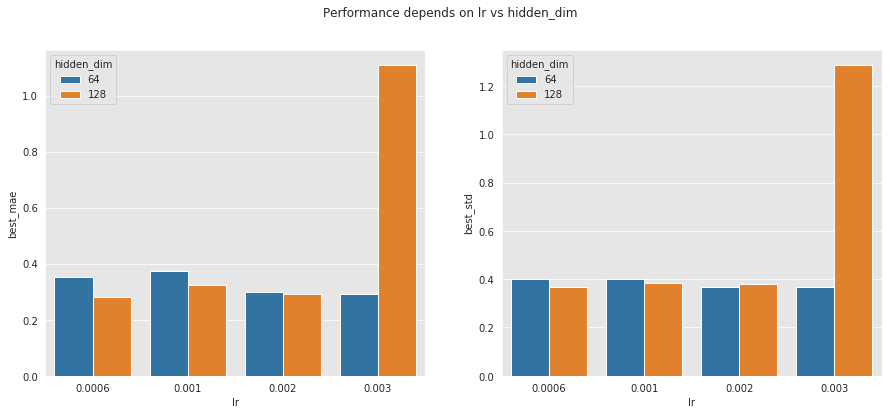

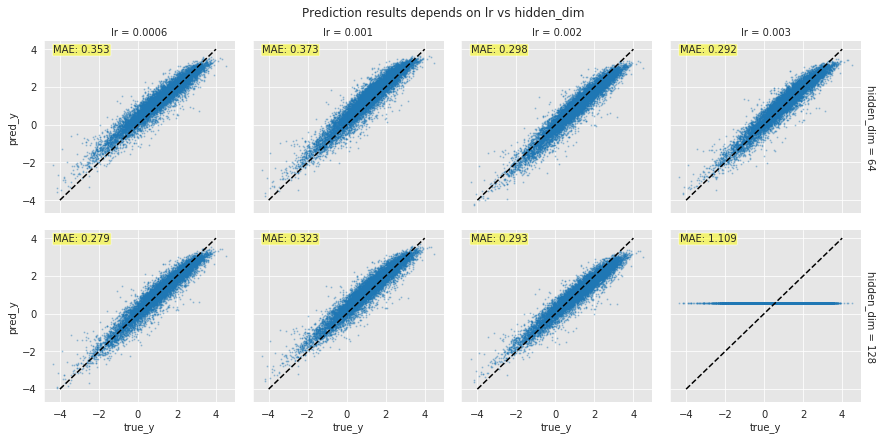

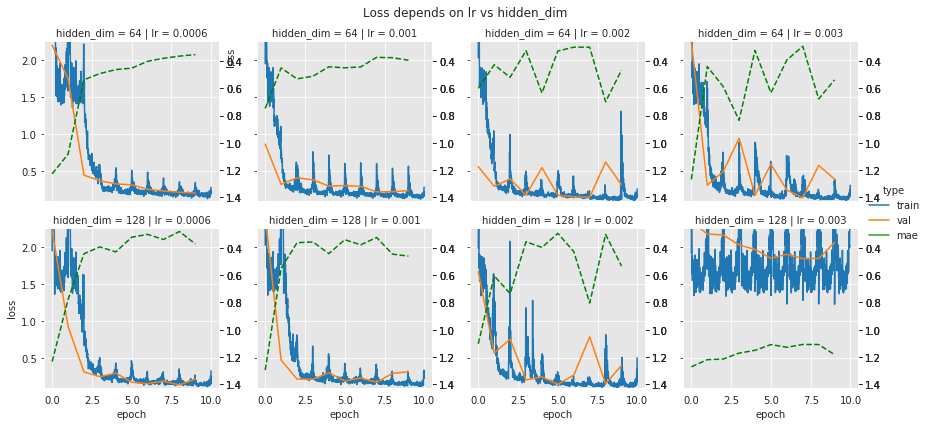

In [21]:
 
results = writer.read(exp_name='exp1_test')

variable2 = 'hidden_dim'
variable1 = 'lr'

plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9, quantile=0.98)

plt.show()


# Experiment.2 Learning rate vs N layer

In [59]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp1_test2'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 2
args.hidden_dim = 64
args.reg_dim = 128
args.output_dim = 1
args.vocab_size = len(CHAR_SMILE.vocab)

args.dropout = 0.1
args.emb_train = False
args.bidirectional = False
args.skip_connection = False
args.cell_type = 'lstm'
args.norm_type = 'None'

args.lr = 0.01
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 10
args.batch_size= 512
args.test_batch_size= 512
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'hidden_dim', 'output_dim', 
                               'dropout', 'emb_train', 'bidirectional', 
                               'skip_connection', 'cell_type', 'norm_type', 
                               'epoch', 'l2_coef', 'lr'])

# ===== Construct Dataloader from dataset ===== #
train_iter, val_iter = BucketIterator.splits(
    (train_dataset, val_dataset),
    batch_sizes=(args.batch_size, args.test_batch_size),
    device='cuda',
    sort_key=lambda x: x.length,
    sort=True,
    sort_within_batch=True,
    repeat=False,
    shuffle=args.shuffle,
)
partition = {'train': train_iter, 'val': val_iter}

# ===== Set Up experiment variable ===== #
# Define Hyperparameter Search Space
list_var1 = [0.0006, 0.001, 0.002, 0.003] #,2,3,4] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [64, 128] #, 2, 3]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

n_iter = args.epoch * (len(train_dataset) + len(val_dataset))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))


# ===== Conduct Experiment ===== #
writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        args.lr = var1
        args.hidden_dim = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))
    

Trainable   Parameters : 152401


/home/jaeyoung/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


[Exp  1] got mae: 0.353, std: 0.402 at epoch 10 took 45.4sec
Trainable   Parameters : 152401
[Exp  2] got mae: 0.373, std: 0.399 at epoch 10 took 45.9sec
Trainable   Parameters : 152401


KeyboardInterrupt: 

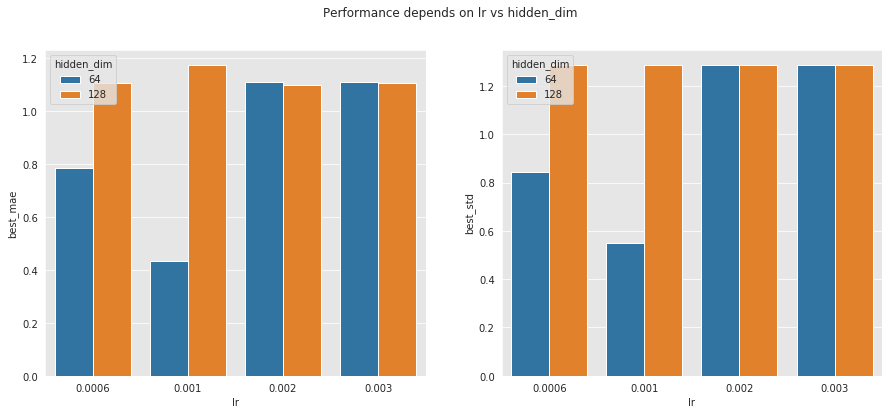

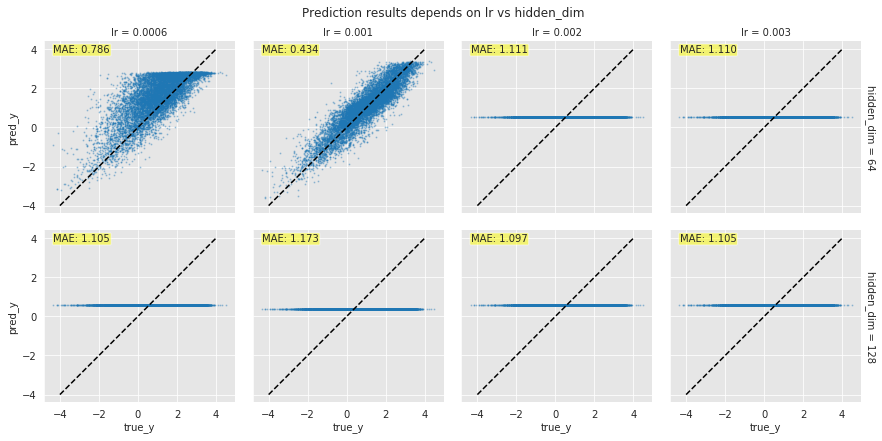

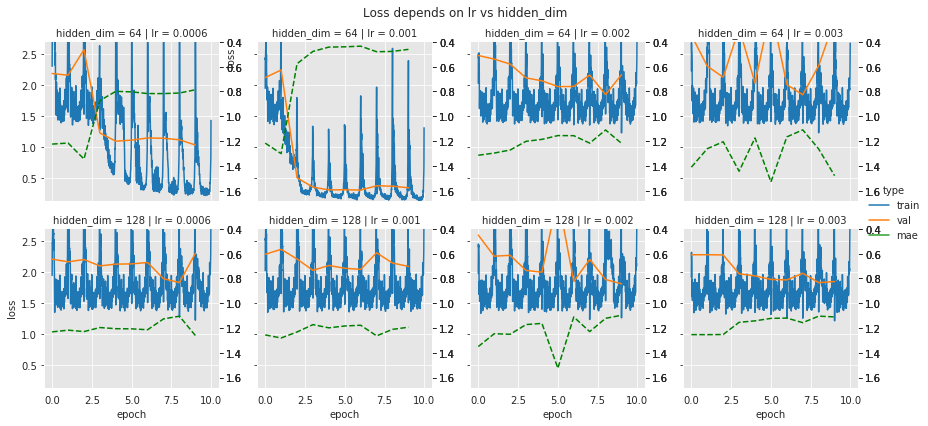

In [45]:
 
results = writer.read(exp_name='exp1_test2')

variable2 = 'hidden_dim'
variable1 = 'lr'

plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9, quantile=0.98)

plt.show()


In [44]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp2_n_layer_lr'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 2
args.hidden_dim = 64
args.reg_dim = 128
args.output_dim = 1
args.vocab_size = len(CHAR_SMILE.vocab)

args.dropout = 0.1
args.emb_train = False
args.bidirectional = False
args.skip_connection = False
args.cell_type = 'lstm'
args.norm_type = 'None'

args.lr = 0.0006
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 10
args.batch_size= 512
args.test_batch_size= 512
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'hidden_dim', 'output_dim', 
                               'dropout', 'emb_train', 'bidirectional', 
                               'skip_connection', 'cell_type', 'norm_type', 
                               'epoch', 'l2_coef', 'lr'])

# ===== Construct Dataloader from dataset ===== #
train_iter, val_iter = BucketIterator.splits(
    (train_dataset, val_dataset),
    batch_sizes=(args.batch_size, args.test_batch_size),
    device='cuda',
    sort_key=lambda x: x.length,
    sort=True,
    sort_within_batch=True,
    repeat=False,
    shuffle=args.shuffle,
)
partition = {'train': train_iter, 'val': val_iter}

# ===== Set Up experiment variable ===== #
# Define Hyperparameter Search Space
list_var1 = [0.0003, 0.0006, 0.001] #,2,3,4] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [2, 3, 4, 5] #, 2, 3]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

n_iter = args.epoch * (len(train_dataset) + len(val_dataset))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))


# ===== Conduct Experiment ===== #
writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        args.lr = var1
        args.n_layer = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))
    

Trainable   Parameters : 557713


/home/jaeyoung/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


[Exp  1] got mae: 0.849, std: 1.028 at epoch 10 took 48.8sec
Trainable   Parameters : 557713
[Exp  2] got mae: 1.151, std: 1.286 at epoch 10 took 48.5sec
Trainable   Parameters : 557713
[Exp  3] got mae: 1.103, std: 1.286 at epoch 10 took 48.8sec
Trainable   Parameters : 1218193
[Exp  4] got mae: 1.139, std: 1.286 at epoch 10 took 79.0sec
Trainable   Parameters : 1218193
[Exp  5] got mae: 1.168, std: 1.286 at epoch 10 took 78.9sec
Trainable   Parameters : 1218193
[Exp  6] got mae: 1.105, std: 1.286 at epoch 10 took 79.0sec
Trainable   Parameters : 2142865
[Exp  7] got mae: 1.116, std: 1.286 at epoch 10 took 122.7sec
Trainable   Parameters : 2142865
[Exp  8] got mae: 1.131, std: 1.286 at epoch 10 took 123.5sec
Trainable   Parameters : 2142865
[Exp  9] got mae: 1.113, std: 1.286 at epoch 10 took 123.5sec
Trainable   Parameters : 3331729
[Exp 10] got mae: 1.139, std: 1.286 at epoch 10 took 185.8sec
Trainable   Parameters : 3331729
[Exp 11] got mae: 1.132, std: 1.286 at epoch 10 took 186.0

In [31]:
a = (1,2)
print(isinstance(a, tuple))

True
